### Import Statements

In [1]:
import os
import cv2
import pylab
import dlib
import numpy as np
import pandas as pd
#import imageio
import skimage.io as imageio
import sys
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
#from keras.utils import multi_gpu_model
from keras.optimizers import SGD, RMSprop
from tensorflow.keras.optimizers import Adam
from keras.layers import Concatenate, Input, concatenate, add, multiply, maximum, LSTM, Reshape
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation
from sklearn import preprocessing
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
#K.set_image_dim_ordering('th')
#K.set_image_data_format('channels_first')
#import matplotlib
#matplotlib.use('Agg')

### GPU Check

In [2]:
gpu_available = tf.config.list_physical_devices('GPU')

In [3]:
gpu_available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### DLib Face Detection

In [5]:
predictor_path = "/Thesis/MicroExpSTCNN/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [87]:
def get_landmark(img):
    rects = detector(img, 0)
    if len(rects) > 1:
        pass
    if len(rects) == 0:
        pass
    ans = np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])
    return ans

In [7]:
def annotate_landmarks(img, landmarks, font_scale = 0.4):
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(img, str(idx), pos, fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, fontScale=font_scale, color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

In [90]:
new_path = '/Thesis/Sample_dataset/006/006_1_2/006_05626.jpg'
smic_img = '/Thesis/Sample_dataset/smic_img.jpg'
samm_img = '/Thesis/Sample_dataset/samm_img.jpg' 
full_img = '/Thesis/Sample_dataset/full_img.jpg'
crop_img = '/Thesis/Sample_dataset/crop_img.jpg'

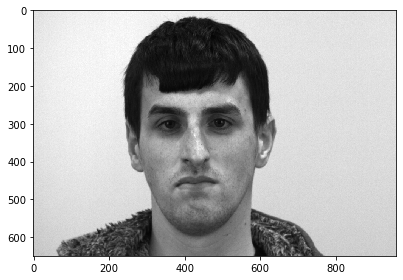

In [91]:
image_new = cv2.imread(samm_img)
image_new = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)
imageio.imshow(image_new)

#### Manual Cropping

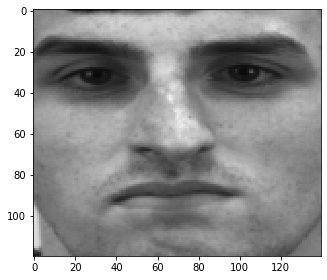

In [92]:
image = cv2.imread(samm_img)
landmarks = get_landmark(image)
numpylandmarks = np.asarray(landmarks)
#left_eye_image = image[numpylandmarks[38][1]-60:numpylandmarks[41][1]+30, numpylandmarks[36][0]-50:numpylandmarks[39][0]+30]
total_face_image = image[numpylandmarks[20][1]-40:numpylandmarks[9][1]-30, numpylandmarks[0][0]+30:numpylandmarks[16][0]-30]
total_face_image = cv2.cvtColor(total_face_image, cv2.COLOR_BGR2GRAY)
total_face_image = cv2.resize(total_face_image, (140, 120), interpolation = cv2.INTER_AREA)
imageio.imshow(total_face_image)

(60, 80)

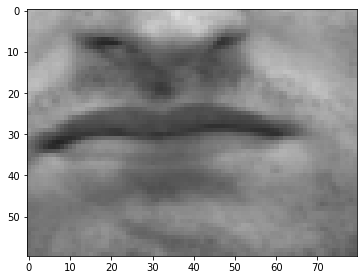

In [93]:
nose_mouth = total_face_image[60:120,35:115]
imageio.imshow(nose_mouth)
nose_mouth.shape

(50, 65)

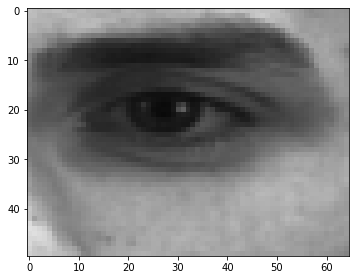

In [94]:
left_eye = total_face_image[10:60,75:140]
imageio.imshow(left_eye)
left_eye.shape

(50, 65)

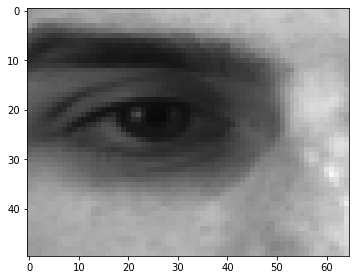

In [95]:
right_eye = total_face_image[10:60,5:70]
imageio.imshow(right_eye)
right_eye.shape

### Cropping of parts

In [96]:
image_new = cv2.imread(samm_img)
image_new = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)
landmarks = get_landmark(image_new)
numpylandmarks = np.asarray(landmarks)

In [97]:
total_face = image_new[numpylandmarks[20][1]-40:numpylandmarks[9][1]-30, numpylandmarks[0][0]+30:numpylandmarks[16][0]-30]
left_eye_image = image_new[numpylandmarks[38][1]-60:numpylandmarks[41][1]+30, numpylandmarks[36][0]-50:numpylandmarks[39][0]+30]
right_eye_image = image_new[numpylandmarks[43][1]-60:numpylandmarks[46][1]+30, numpylandmarks[42][0]-40:numpylandmarks[45][0]+40]
nose_mouth_image = image_new[numpylandmarks[2][1]+20:numpylandmarks[6][1]-30, numpylandmarks[2][0]+70:numpylandmarks[14][0]-80]

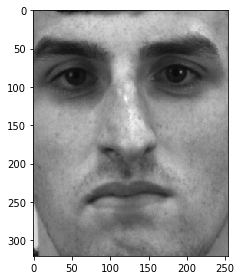

In [98]:
imageio.imshow(total_face)

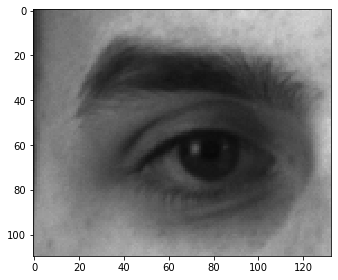

In [99]:
imageio.imshow(left_eye_image)

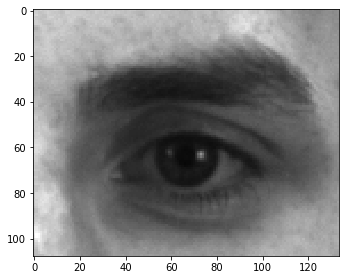

In [100]:
imageio.imshow(right_eye_image)

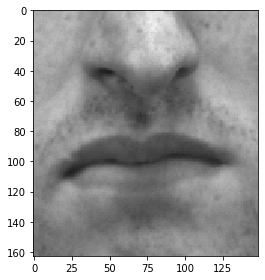

In [105]:
nose_mouth_image = image_new[numpylandmarks[29][1]:numpylandmarks[6][1]-30, numpylandmarks[2][0]+70:numpylandmarks[14][0]-80]
imageio.imshow(nose_mouth_image)

In [102]:
total_face.shape

(321, 254)

In [ ]:
labelpath = '/Thesis/Sample_dataset/'
directorylisting = os.listdir(labelpath)
print(directorylisting)

In [ ]:
frames_Count = 5
labelpath = '/Thesis/Sample_dataset/'
directorylisting = os.listdir(labelpath)
for video in directorylisting:
    frames = []
    count = 0
    left_eye_frames = []
    videopath = labelpath + video + '/'
    Num_videos = os.listdir(videopath)
    for vd in Num_videos:
        framepath = videopath + vd
        framelisting = os.listdir(framepath)
        count = count+1
        if len(framelisting) > frames_Count:
            print('Video :  ',vd, '        Number of frames : ',len(framelisting))

In [ ]:
frames_Count = 5
left_eye_training_list = []

In [ ]:
labelpath = '/Thesis/Sample_dataset/'
directorylisting = os.listdir(labelpath)
for sub in directorylisting:
    count = 0
    sub_path = labelpath + sub + '/'
    num_videos = os.listdir(sub_path)
    for vd in num_videos:
        framepath = sub_path + vd
        frames = []
        left_eye_frames = []
        framelisting = os.listdir(framepath)
        count = count+1
        if len(framelisting) > frames_Count:
            #print('Video :  ',vd, '        Number of frames : ',len(framelisting))
            framerange = [x  for x in range(frames_Count)]
            for frame in framerange:
                imagepath = framepath + '/' + framelisting[frame]
                image = cv2.imread(imagepath)
                landmarks = get_landmark(image)
                numpylandmarks = np.asarray(landmarks)
                left_eye_image = image[numpylandmarks[38][1]-60:numpylandmarks[41][1]+30, numpylandmarks[36][0]-50:numpylandmarks[39][0]+30]
                left_eye_image = cv2.resize(left_eye_image, (40, 50), interpolation = cv2.INTER_AREA)
                left_eye_image = cv2.cvtColor(left_eye_image, cv2.COLOR_BGR2GRAY)
                left_eye_image = np.expand_dims(left_eye_image, axis=2)
                #left_eye_image = np.rollaxis(np.rollaxis(left_eye_image, 1, 0), 2, 1)
                left_eye_frames.append(left_eye_image)
            left_eye_frames = np.asarray(left_eye_frames)
            left_eye_videoarray = np.rollaxis(np.rollaxis(left_eye_frames, 1, 0), 2, 1)
            #left_eye_videoarray = np.rollaxis(np.rollaxis(left_eye_frames, 2, 0), 2, 0)
            left_eye_training_list.append(left_eye_videoarray)

#     print(count)
    # break

In [ ]:
left_eye_training_list[1].shape

### Loading Excel to DataFrame

In [ ]:
df = pd.read_excel('/Thesis/Datasets/CASME2/CASME2-coding-20190701.xlsx') #index_col=0

In [ ]:
df.count()

In [ ]:
df.head()

In [ ]:
df['Estimated Emotion'].value_counts()

In [ ]:
df['Subject'] = df['Subject'].astype(str)
df['Sub_FileName'] = df[['Subject', 'Filename']].apply(lambda x: '_'.join(x), axis=1)
df.head(5)

In [ ]:
positive = df[df['Estimated Emotion'] == 'happiness']['Sub_FileName']#[['Subject','Filename']]
print('Positive :', positive.count())

negative = df[(df['Estimated Emotion'] == 'disgust') | (df['Estimated Emotion'] == 'repression') | (df['Estimated Emotion'] == 'fear') | (df['Estimated Emotion'] == 'sadness')]['Sub_FileName']
print('Negative :',negative.count())

surprise = df[df['Estimated Emotion'] == 'surprise']['Sub_FileName']
print('Surprise :',surprise.count())

### Initialization

In [ ]:
subjectPath = '/Thesis/Datasets/CASME2/CASME2_RAW_selected/'

In [ ]:
i, j, k = 0, 0, 0

frames_Count = 48
# left_eye_training_list = []
# right_eye_training_list = []
# mouth_training_list = []
total_face_training_list = []

### CASME-II Dataset

In [ ]:
sub_count = 0
for lab in [positive, negative, surprise]: 
    subDirectory = lab#.tolist() 
    count = 0
    for sub in tqdm(subDirectory):
        sub = str(sub).split('_')
        labelpath = '/Thesis/Datasets/CASME2/CASME2_RAW_selected/'+'sub'+ sub[0].zfill(2) +'/'
        directorylisting = os.listdir(labelpath)
        for video in directorylisting:
            if video == str(sub[1]+'_'+sub[2]):
                frames = []
                left_eye_frames = []
                right_eye_frames = []
                mouth_frames = []
                total_face_frames = []
                videopath = labelpath + video
                framelisting = os.listdir(videopath)
                if len(framelisting) > frames_Count:
                    framerange = [x  for x in range(frames_Count)]
                    count = count + 1
                    for frame in framerange:
                        imagepath = videopath + "/" + framelisting[frame]
                        image = cv2.imread(imagepath)
                        # landmarks = get_landmark(image)
                        # numpylandmarks = np.asarray(landmarks)
                        
#                         left_eye_image = image[numpylandmarks[38][1]-60:numpylandmarks[41][1]+30, numpylandmarks[36][0]-50:numpylandmarks[39][0]+30]
#                         left_eye_image = cv2.resize(left_eye_image, (40, 50), interpolation = cv2.INTER_AREA)
#                         left_eye_image = cv2.cvtColor(left_eye_image, cv2.COLOR_BGR2GRAY)
#                         left_eye_image = np.expand_dims(left_eye_image, axis=2)
                        
#                         right_eye_image = image[numpylandmarks[43][1]-60:numpylandmarks[46][1]+30, numpylandmarks[42][0]-40:numpylandmarks[45][0]+40]
#                         right_eye_image = cv2.resize(right_eye_image, (40, 50), interpolation = cv2.INTER_AREA)
#                         right_eye_image = cv2.cvtColor(right_eye_image, cv2.COLOR_BGR2GRAY)
#                         right_eye_image = np.expand_dims(right_eye_image, axis=2)
                        
#                         mouth_image = image[numpylandmarks[2][1]+20:numpylandmarks[6][1]-30, numpylandmarks[2][0]+70:numpylandmarks[14][0]-80]
#                         mouth_image = cv2.resize(mouth_image, (80, 30), interpolation = cv2.INTER_AREA)
#                         mouth_image = cv2.cvtColor(mouth_image, cv2.COLOR_BGR2GRAY)
#                         mouth_image = np.expand_dims(mouth_image, axis=2)
                        
                        # total_face_image = image[numpylandmarks[20][1]-40:numpylandmarks[9][1]-30, numpylandmarks[0][0]+30:numpylandmarks[16][0]-30]
                        total_face_image = cv2.resize(image, (140, 120), interpolation = cv2.INTER_AREA)
                        total_face_image = cv2.cvtColor(total_face_image, cv2.COLOR_BGR2GRAY)
                        total_face_image = np.expand_dims(total_face_image, axis=2)
                        
                        # left_eye_frames.append(left_eye_image)
                        # right_eye_frames.append(right_eye_image)
                        # mouth_frames.append(mouth_image)
                        total_face_frames.append(total_face_image)
                        
                    # left_eye_frames = np.asarray(left_eye_frames)
                    # right_eye_frames = np.asarray(right_eye_frames)
                    # mouth_frames = np.asarray(mouth_frames)
                    total_face_frames = np.asarray(total_face_frames)
                    # total_face_videoarray = np.rollaxis(np.rollaxis(total_face_frames, 1, 0), 2, 1)
                    # left_eye_videoarray = np.rollaxis(np.rollaxis(left_eye_frames, 2, 0), 2, 0)
                    # right_eye_videoarray = np.rollaxis(np.rollaxis(right_eye_frames, 2, 0), 2, 0)
                    # mouth_videoarray = np.rollaxis(np.rollaxis(mouth_frames, 2, 0), 2, 0)
                    # total_face_videoarray = np.rollaxis(np.rollaxis(total_face_frames, 2, 0), 2, 0)

                    # left_eye_training_list.append(left_eye_frames)
                    # right_eye_training_list.append(right_eye_frames)
                    # mouth_training_list.append(mouth_frames)
                    total_face_training_list.append(total_face_frames)
                    #break

    print(count)
    # break

In [106]:
print("Hello Git Testing")

Hello Git Testing


In [ ]:
total_face_frames.shape

In [ ]:
len(total_face_training_list)

In [ ]:
total_face_training_list[122].shape

In [ ]:
# left_eye_training_list = np.asarray(left_eye_training_list)
# right_eye_training_list = np.asarray(right_eye_training_list)
# mouth_training_list = np.asarray(mouth_training_list)
total_face_training_list = np.asarray(total_face_training_list)

# left_eye_trainingsamples = len(left_eye_training_list)
# right_eye_trainingsamples = len(right_eye_training_list)
# mouth_trainingsamples = len(mouth_training_list)
total_face_trainingsamples = len(total_face_training_list)

# left_eye_traininglabels = np.zeros((left_eye_trainingsamples, ), dtype = int)
# right_eye_traininglabels = np.zeros((right_eye_trainingsamples, ), dtype = int)
# mouth_traininglabels = np.zeros((mouth_trainingsamples, ), dtype = int)
total_face_traininglabels = np.zeros((total_face_trainingsamples, ), dtype = int)

In [ ]:
# left_eye_traininglabels[0:32] = 0
# left_eye_traininglabels[32:126] = 1
# left_eye_traininglabels[126:154] = 2

# right_eye_traininglabels[0:32] = 0
# right_eye_traininglabels[32:126] = 1
# right_eye_traininglabels[126:154] = 2

# mouth_traininglabels[0:32] = 0
# mouth_traininglabels[32:126] = 1
# mouth_traininglabels[126:154] = 2

total_face_traininglabels[0:27] = 0
total_face_traininglabels[27:103] = 1
total_face_traininglabels[103:124] = 2

In [ ]:
# left_eye_traininglabels = np_utils.to_categorical(left_eye_traininglabels, 3)
# right_eye_traininglabels = np_utils.to_categorical(right_eye_traininglabels, 3)
# mouth_traininglabels = np_utils.to_categorical(mouth_traininglabels, 3)
total_face_traininglabels = np_utils.to_categorical(total_face_traininglabels, 3)

In [ ]:
left_eye_training_data = [left_eye_training_list, left_eye_traininglabels]
(left_eye_training_set, left_eye_traininglabels) = (left_eye_training_data[0], left_eye_training_data[1])

In [ ]:
left_eye_training_set = left_eye_training_set.astype('float32')
left_eye_training_set -= np.mean(left_eye_training_set)
left_eye_training_set /= np.max(left_eye_training_set)

In [ ]:
right_eye_training_data = [right_eye_training_list, right_eye_traininglabels]
(right_eye_training_set, right_eye_traininglabels) = (right_eye_training_data[0], right_eye_training_data[1])

In [ ]:
right_eye_training_set = right_eye_training_set.astype('float32')
right_eye_training_set -= np.mean(right_eye_training_set)
right_eye_training_set /= np.max(right_eye_training_set)

In [ ]:
mouth_training_data = [mouth_training_list, mouth_traininglabels]
(mouth_training_set, mouth_traininglabels) = (mouth_training_data[0], mouth_training_data[1])

In [ ]:
mouth_training_set = mouth_training_set.astype('float32')
mouth_training_set -= np.mean(mouth_training_set)
mouth_training_set /= np.max(mouth_training_set)

In [ ]:
total_face_training_data = [total_face_training_list, total_face_traininglabels]
(total_face_training_set, total_face_traininglabels) = (total_face_training_data[0], total_face_training_data[1])

In [ ]:
total_face_training_set = total_face_training_set.astype('float32')
total_face_training_set -= np.mean(total_face_training_set)
total_face_training_set /= np.max(total_face_training_set)

In [ ]:
np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/left_eye_images.npy', left_eye_training_set)
np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/left_eye_labels.npy', left_eye_traininglabels)

np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/right_eye_images.npy', right_eye_training_set)
np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/right_eye_labels.npy', right_eye_traininglabels)

np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/mouth_images.npy', mouth_training_set)
np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/mouth_labels.npy', mouth_traininglabels)

np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/face_images.npy', total_face_training_set)
np.save('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/face_labels.npy', total_face_traininglabels)

In [ ]:
# Load training images and labels that are stored in numpy array

left_eye_training_set = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/left_eye_images.npy')
left_eye_traininglabels = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/left_eye_labels.npy')

right_eye_training_set = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/right_eye_images.npy')
right_eye_traininglabels = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/right_eye_labels.npy')

mouth_training_set = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/mouth_images.npy')
mouth_traininglabels = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/mouth_labels.npy')

total_face_training_set = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/face_images.npy')
total_face_traininglabels = np.load('/Thesis/Multi_Scale_MicroExp/Training_dataset_CASME/face_labels.npy')

In [ ]:
total_face_training_set.shape

In [ ]:
face_input = Input(shape = (48, 30, 80, 1))
face_conv = Convolution3D(16, (3, 3, 3))(face_input)
face_ract_1 = Activation('relu')(face_conv)
face_max = MaxPooling3D(pool_size=(3, 3, 3))(face_ract_1)
print(face_max.shape)
# face_reshape = tf.keras.layers.Reshape((4, 39 * 46 * 16))(face_max)
# face_lstm = tf.keras.layers.LSTM(units = 512)(face_reshape)

### Network Architecture

In [ ]:
# left_eye_input = Input(shape = (48, 50, 40, 1))
# left_eye_conv = Convolution3D(16, (3, 3, 3))(left_eye_input)
# left_ract_1 = Activation('relu')(left_eye_conv)
# left_eye_max = MaxPooling3D(pool_size=(3, 3, 3))(left_ract_1)
# left_eye_reshape = tf.keras.layers.Reshape((15, 16 * 12 * 16))(left_eye_max)
# left_eye_lstm = tf.keras.layers.LSTM(units = 512)(left_eye_reshape)
# #left_dropout_1 = Dropout(0.5)(left_eye_max)
# left_eye_flatten = Flatten()(left_eye_lstm)

# right_eye_input = Input(shape = (48, 50, 40, 1))
# right_eye_conv = Convolution3D(16, (3, 3, 3))(right_eye_input)
# right_ract_1 = Activation('relu')(right_eye_conv)
# right_eye_max = MaxPooling3D(pool_size=(3, 3, 3))(right_ract_1)
# right_eye_reshape = tf.keras.layers.Reshape((15, 16 * 12 * 16))(right_eye_max)
# right_eye_lstm = tf.keras.layers.LSTM(units = 512)(right_eye_reshape)
# #right_dropout_1 = Dropout(0.5)(right_eye_max)
# right_eye_flatten = Flatten()(right_eye_lstm)

# mouth_input = Input(shape = (48, 30, 80, 1))
# mouth_conv = Convolution3D(16, (3, 3, 3))(mouth_input)
# mouth_ract_1 = Activation('relu')(mouth_conv)
# mouth_max = MaxPooling3D(pool_size=(3, 3, 3))(mouth_ract_1)
# mouth_reshape = tf.keras.layers.Reshape((15, 9 * 26 * 16))(mouth_max)
# mouth_lstm = tf.keras.layers.LSTM(units = 512)(mouth_reshape)
# #mouth_dropout_1 = Dropout(0.5)(mouth_max)
# mouth_flatten = Flatten()(mouth_lstm)

# face_input = Input(shape = (120, 140, 48, 1))
# face_conv = Convolution3D(16, (3, 3, 3))(face_input)
# face_ract_1 = Activation('relu')(face_conv)
# face_max = MaxPooling3D(pool_size=(3, 3, 3))(face_ract_1)
# #face_reshape = tf.keras.layers.Reshape((15, 39 * 46 * 16))(face_max)
# #face_lstm = tf.keras.layers.LSTM(units = 512)(face_reshape)
# face_dropout_1 = Dropout(0.5)(face_max)
# face_flatten = Flatten()(face_dropout_1)

# #result = Concatenate(axis = 1)([left_eye_flatten, right_eye_flatten, mouth_flatten, face_flatten])
# #dense_1 = Dense(1024, )(face_flatten)
# #dropout_4 = Dropout(0.5)(dense_1)
# dense_2 = Dense(128, )(face_flatten)
# dropout_5 = Dropout(0.5)(dense_2)
# dense_3 = Dense(3, activation='relu')(dropout_5)
# activation = Activation('softmax')(dense_3)

model = Sequential()
model.add(Convolution3D(32, (3, 3, 15), input_shape=(48, 120, 140, 1), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

#model = Model(inputs = face_input, outputs = activation)

#model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

filepath="weights_IF/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

In [ ]:
# Load pre-trained weights
#model.load_weights('weights_intermediate_microexpfusenet/weights-improvement-22-0.83.hdf5')

In [ ]:
# Spliting the dataset into training and validation sets
# le_train_images, le_validation_images, le_train_labels, le_validation_labels =  train_test_split(left_eye_training_set, left_eye_traininglabels, test_size=0.2, shuffle=False)
# re_train_images, re_validation_images, re_train_labels, re_validation_labels =  train_test_split(right_eye_training_set, right_eye_traininglabels, test_size=0.2, shuffle=False)
# m_train_images, m_validation_images, m_train_labels, m_validation_labels =  train_test_split(mouth_training_set, mouth_traininglabels, test_size=0.2, shuffle=False)
f_train_images, f_validation_images, f_train_labels, f_validation_labels =  train_test_split(total_face_training_set, total_face_traininglabels, test_size=0.2, shuffle=False)

In [ ]:
# Save validation set in a numpy array
np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/le_val_images.npy', le_validation_images)
np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/le_val_labels.npy', le_validation_labels)

np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/re_val_images.npy', re_validation_images)
np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/re_val_labels.npy', re_validation_labels)

np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/m_val_images.npy', m_validation_images)
np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/m_val_labels.npy', m_validation_labels)

np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/f_val_images.npy', f_validation_images)
np.save('/Thesis/Multi_Scale_MicroExp/validation_data_CASME/f_val_labels.npy', f_validation_labels)

In [ ]:
# Training the model
history = model.fit(f_train_images, f_train_labels, validation_data = (f_validation_images, f_validation_labels), callbacks=callbacks_list, batch_size = 16, epochs = 100, shuffle=True)

In [ ]:
# Loading Load validation set from numpy array
eimg = np.load('/Thesis/MicroExpSTCNN/Eval_dataset_CASME/intermediate_microexpfusenet_eval_images.npy')
nimg = np.load('/Thesis/MicroExpSTCNN/Eval_dataset_CASME/intermediate_microexpfusenet_nval_images.npy')
labels = np.load('/Thesis/MicroExpSTCNN/Eval_dataset_CASME/intermediate_microexpfusenet_eval_labels.npy')

In [ ]:
# Finding Confusion Matrix using pretrained weights
predictions = model.predict([eimg, nimg])
predictions_labels = np.argmax(predictions, axis=1)
validation_labels = np.argmax(labels, axis=1)
cfm = confusion_matrix(validation_labels, predictions_labels)
print (cfm)

In [ ]:
f_train_image, f_test_image, y_train, y_test =  train_test_split( total_face_training_set, total_face_traininglabels, test_size=0.2, shuffle=False)

# le_train_label = y_train
# le_test_label = y_test

# re_train_label = y_train
# re_test_label = y_test

# m_train_label = y_train
# m_test_label = y_test

f_train_label = y_train
f_test_label = y_test

# Convert Into Tensors
# le_train_data = tf.data.Dataset.from_tensor_slices((le_train_image, le_train_label)).batch(8, drop_remainder=True)
# le_test_data = tf.data.Dataset.from_tensor_slices((le_test_image, le_test_label)).batch(8, drop_remainder=True)

# re_train_data = tf.data.Dataset.from_tensor_slices((re_train_image, re_train_label)).batch(8, drop_remainder=True)
# re_test_data = tf.data.Dataset.from_tensor_slices((re_test_image, re_test_label)).batch(8, drop_remainder=True)

# m_train_data = tf.data.Dataset.from_tensor_slices((m_train_image, m_train_label)).batch(8, drop_remainder=True)
# m_test_data = tf.data.Dataset.from_tensor_slices((m_test_image, m_test_label)).batch(8, drop_remainder=True)

f_train_data = tf.data.Dataset.from_tensor_slices((f_train_image, f_train_label)).batch(8, drop_remainder=True)
f_test_data = tf.data.Dataset.from_tensor_slices((f_test_image, f_test_label)).batch(8, drop_remainder=True)

# Use the below dataset for model.fit
# train_All_dataset = tf.data.Dataset.from_tensor_slices(({"NET_A_InputLayer": x_train_A, "NET_B_InputLayer": x_train_B}, y_train_A)).batch(8, drop_remainder=True)
# test_All_dataset = tf.data.Dataset.from_tensor_slices(({"NET_A_InputLayer": x_test_A, "NET_B_InputLayer": x_test_B}, y_test_A)).batch(8, drop_remainder=True)


In [ ]:
optimizer = Adam(learning_rate=1e-3)  # tune this
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
EPOCHS = 100

for epoch in range(EPOCHS):
    print("Epoch : ", epoch+1)
    for step, (image_batch1, label_batch1) in enumerate((f_train_data)):
        with tf.GradientTape() as tape:
            logits = model([image_batch1])
            # loss format is generally: first argument targets, second argument outputs
            loss = loss_fn(label_batch1, logits)

        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))
        
        train_acc_metric(label_batch1, logits)
        if not step % 4:
            print("Step: {} Loss: {} Accuracy: {}".format(step, loss, train_acc_metric.result()))
            train_acc_metric.reset_states()

In [ ]:
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
for  step, (image_batch1, label_batch1) in enumerate((f_test_data)):
    test_acc_metric(label_batch1, model([image_batch1]))
print("Test acc: {}".format(test_acc_metric.result()))